Dataset Analysis

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import sklearn.metrics

import os
import PIL  #to read images
import matplotlib.pyplot as plt
import random
import torch.optim as optim

from numba import cuda 


In [2]:
df = pd.read_csv('archive/cards.csv')
df = df[df.filepaths.str.endswith('.jpg')]  #sanity check to pick only jpg files
print(df)
print("number of classes = ",df.iloc[:,0].unique().size)
print("number of card type = ",df.iloc[:,-2].unique().size)

      class index                   filepaths         labels card type  \
0               0  train/ace of clubs/001.jpg   ace of clubs       ace   
1               0  train/ace of clubs/002.jpg   ace of clubs       ace   
2               0  train/ace of clubs/003.jpg   ace of clubs       ace   
3               0  train/ace of clubs/004.jpg   ace of clubs       ace   
4               0  train/ace of clubs/005.jpg   ace of clubs       ace   
...           ...                         ...            ...       ...   
8150           52   valid/two of spades/1.jpg  two of spades       two   
8151           52   valid/two of spades/2.jpg  two of spades       two   
8152           52   valid/two of spades/3.jpg  two of spades       two   
8153           52   valid/two of spades/4.jpg  two of spades       two   
8154           52   valid/two of spades/5.jpg  two of spades       two   

     data set  
0       train  
1       train  
2       train  
3       train  
4       train  
...       ...  

Preprocessing


cuda:0
<CUDA device 0 'b'NVIDIA GeForce RTX 3050 Ti Laptop GPU''>


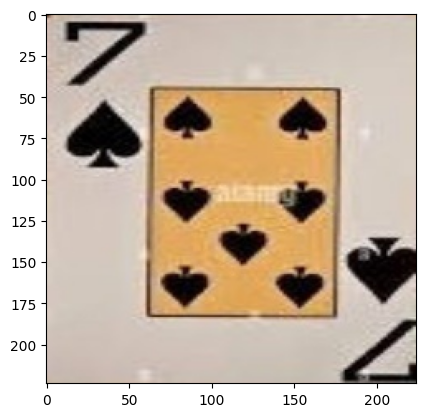

In [3]:
class RotationTransform(nn.ModuleList):

    def __init__(self, angles):
        super(RotationTransform, self).__init__()
        self.angles = angles

    def forward(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

rotation_transform = RotationTransform(angles=[-30, -15, 0, 15, 30])

transforms=T.RandomApply(torch.nn.ModuleList([      #augmentation module
T.ColorJitter(brightness=0.4,contrast=0.4,saturation=0.4),rotation_transform ]), p=0.3)


class CustomDataset(Dataset):
    def __init__(self, data_frame, root_dir, partition):
        super(CustomDataset, self).__init__()
        self.data_frame = data_frame[data_frame['data set'] == partition] #the split 
        self.root_dir = root_dir
        self.split=partition
        
        self.lbl_to_int = {
            lbl: i for i, lbl 
            in enumerate(self.data_frame['labels'].unique())
        }
        
        self.crt_to_int = {
            crt: i for i, crt 
            in enumerate(self.data_frame['card type'].unique())
        }

        self.to_crt = {
            v: k for k, v in self.crt_to_int.items()
        }

        self.to_lbl = {
            v: k for k, v in self.lbl_to_int.items()
        }

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        row = self.data_frame.iloc[idx]
        
        relative_path = row.filepaths
        img = PIL.Image.open(os.path.join(self.root_dir, relative_path))
        if self.split == 'train':
            img=transforms(img)
            img=TF.to_tensor(img)
        else:
            img=TF.to_tensor(img)

        
        #lbl = row['labels']
        #lbl = self.lbl_to_int[lbl]
        
        lbl = row['card type']
        lbl = self.crt_to_int[lbl]

        return img, lbl

    def inverse(self, x, y):
        return (
            TF.to_pil_image(x),
            self.to_crt[y]
        )


train_set = CustomDataset(df, 'archive', 'train')
validation_set = CustomDataset(df, 'archive', 'valid')
test_set = CustomDataset(df, 'archive', 'test' )

BATCH_SIZE = 8

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

##########GPU USAGE#######################################################

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)
device = cuda.get_current_device()
print(device)



plt.imshow(TF.to_pil_image(train_set[5300][0]))

    


Building models

In [4]:
class myCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32,64,5,padding=2)
        self.conv4 = nn.Conv2d(64,128,5,padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3=nn.BatchNorm2d(64)
        self.bn4=nn.BatchNorm2d(128)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(128*14*14, 1000)
        self.fc2 = nn.Linear(1000,500)
        self.fc3 = nn.Linear(500,100)
        self.fc4 = nn.Linear(100,14)
        self.drop = nn.Dropout(0.3)

    def forward(self, x):
        identity=x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.max_pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x=self.max_pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x=self.max_pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x=self.max_pool(x)
        #print(x.shape)
        
        x = x.reshape((-1, 128*14*14))
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.drop(F.relu(self.fc3(x)))
        return torch.softmax(self.fc4(x),dim=1)


#net=myCNN()
#net.to(DEVICE)

In [5]:
net=torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
print(net.modules)
num_ftrs = net.fc.in_features
net.fc = torch.nn.Linear(num_ftrs, 14)
net.to(DEVICE)

Using cache found in /home/mf/.cache/torch/hub/pytorch_vision_v0.10.0
/home/mf/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mf/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
loss = nn.CrossEntropyLoss()  #requires 1-hot encoding
optimizer = optim.SGD(net.parameters(), lr=0.001,momentum=0.9)    
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [7]:
def correct_predictions(prediction, target):
    return (
        prediction.argmax(dim=-1) 
        == target.argmax(dim=-1)
    ).sum()

Training and Eval

In [8]:
max_epochs = 20
accuracies=[]
losses=[]
for epoch in range(max_epochs):
    net.train()
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(DEVICE),y.to(DEVICE)
        n = float(x.size(0))  

        y = F.one_hot(y, 14).float()
        optimizer.zero_grad()

        #pred = net(x)
        pred=torch.softmax(net(x),dim=1) #use this for loaded models
        loss_ = loss(pred, y)

        loss_.backward()

        optimizer.step()
            
    net.eval()
    loss_= 0.
    acc = 0.
    total = 0.
    for i, (x, y) in enumerate(validation_loader):
      with torch.no_grad():
        x, y = x.to(DEVICE),y.to(DEVICE)
        n = float(x.size(0))
        total += n
        y = F.one_hot(y, 14).float()
        #pred = net(x)
        pred=torch.softmax(net(x),dim=1) #use this for loaded models
        loss_ += (n * loss(pred, y))
        acc  += float(correct_predictions(pred, y))
    loss_ /= total
    acc  /= total
    losses.append(loss_.cpu())
    accuracies.append(acc)
    
    print(f'epoch{epoch+1:4d} loss: {loss_:.5f}',
          f'accuracy: {acc:.2%} ')
    #scheduler.step()

epoch   1 loss: 2.58757 accuracy: 12.83% 
epoch   2 loss: 2.52390 accuracy: 23.40% 
epoch   3 loss: 2.48789 accuracy: 28.68% 
epoch   4 loss: 2.45294 accuracy: 28.68% 
epoch   5 loss: 2.41767 accuracy: 36.23% 
epoch   6 loss: 2.35459 accuracy: 42.64% 
epoch   7 loss: 2.31602 accuracy: 46.42% 
epoch   8 loss: 2.27675 accuracy: 48.68% 
epoch   9 loss: 2.25996 accuracy: 49.43% 
epoch  10 loss: 2.25610 accuracy: 49.06% 
epoch  11 loss: 2.23099 accuracy: 53.21% 
epoch  12 loss: 2.21561 accuracy: 54.34% 
epoch  13 loss: 2.21539 accuracy: 54.72% 
epoch  14 loss: 2.20382 accuracy: 55.09% 
epoch  15 loss: 2.21488 accuracy: 53.58% 
epoch  16 loss: 2.18870 accuracy: 56.23% 
epoch  17 loss: 2.20351 accuracy: 55.09% 
epoch  18 loss: 2.15479 accuracy: 61.13% 
epoch  19 loss: 2.13645 accuracy: 62.26% 
epoch  20 loss: 2.12213 accuracy: 64.15% 


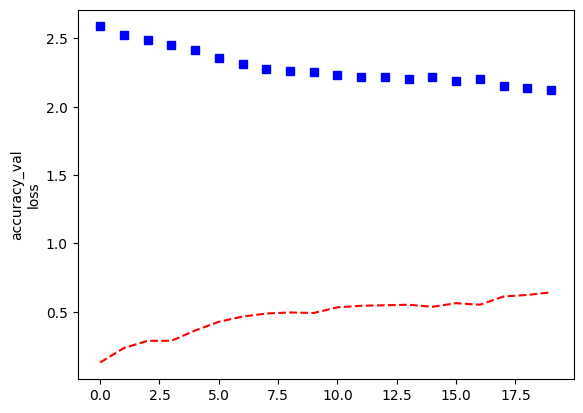

In [9]:
plt.plot(range(max_epochs),accuracies,'r--',range(max_epochs),losses,'bs')
plt.ylabel('accuracy_val\nloss')
plt.show()

Test


tensor(1.)
tensor(1.)
tensor(0.8750)
tensor(1.)
tensor(0.6250)
tensor(0.7500)
tensor(0.7500)
tensor(0.3750)
tensor(0.)
tensor(0.)
tensor(0.8750)
tensor(0.8750)
tensor(0.5000)
tensor(0.8750)
tensor(0.8750)
tensor(0.5000)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.3750)
tensor(0.8750)
tensor(0.7500)
tensor(0.6250)
tensor(0.7500)
tensor(1.)
tensor(0.8750)
tensor(0.7500)
tensor(0.7500)
tensor(1.)
tensor(0.8750)
tensor(0.8750)
tensor(0.6250)
tensor(0.)
Accuracy on the test set: 63.40%


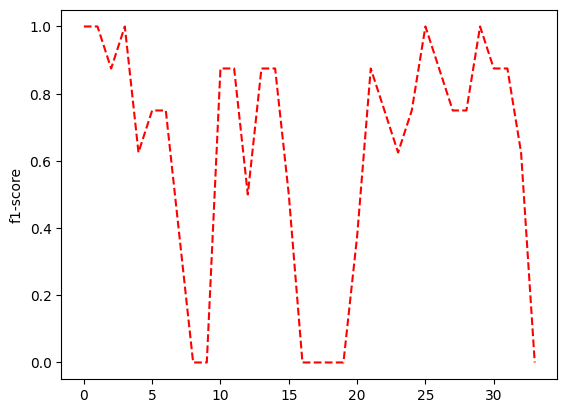

In [10]:
from torchmetrics.classification import MulticlassF1Score
#net=myCNN()
#net.to(DEVICE)
#net.load_state_dict(torch.load("./model"))
net.eval()
acc = 0.
total = 0.
f1 = MulticlassF1Score(task="multiclass", num_classes=14,average='micro')
f1_list=[]

for i, (x, y) in enumerate(test_loader):
  with torch.no_grad():
    x, y = x.to(DEVICE),y.to(DEVICE)
    z = F.one_hot(y, 14).float()             
    n = float(x.size(0))
    total += n
    #pred=net(x)
    pred = torch.softmax(net(x),dim=1)         #loaded models
    acc  += float(correct_predictions(pred, z))
    f1_score=f1(pred.cpu().argmax(dim=-1), y.cpu())
    print(f1_score)
    f1_list.append(f1_score)
acc/=total




print(f"Accuracy on the test set: {acc:.2%}")
x_axis=range(int(test_set.__len__()/BATCH_SIZE)+1)
plt.plot(x_axis,f1_list,'r--')
plt.ylabel('f1-score')
plt.show()
    
    


Save the model

In [30]:
#torch.save(net.state_dict(), "./model")

Test on an external

torch.Size([1, 3, 224, 224])
tensor([[1.4657e-05, 4.6343e-07, 1.5531e-05, 2.0223e-06, 6.4677e-07, 2.3245e-07,
         1.3017e-05, 7.9535e-07, 3.6774e-07, 2.6352e-05, 1.7731e-05, 6.7197e-07,
         2.1207e-05, 9.9989e-01]], grad_fn=<SoftmaxBackward0>)
you got 2!


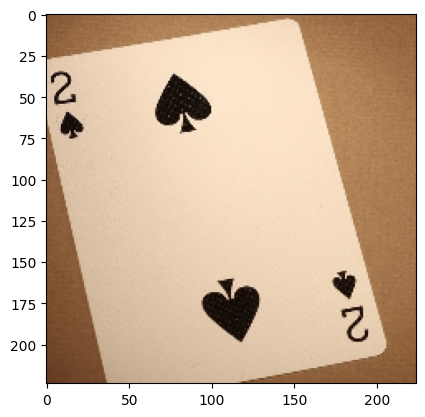

In [29]:

img = PIL.Image.open("./2_picche.jpg")
#img=PIL.Image.open("archive/test/two of spades/4.jpg")
img=TF.to_tensor(img)
img=TF.center_crop(img,[600,600])
img=TF.resize(img,[224,224])
plt.imshow(TF.to_pil_image(img))
img=img.reshape((1,3,224,224))

print(img.shape)
net.to('cpu')
net.eval()
#net.load_state_dict(torch.load("./model"))
pred=torch.softmax(net(img),dim=1)
print(pred)
if(pred.argmax(dim=-1)==13): 
    print("you got 2!")
